In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from glob import glob

from IPython import display
import matplotlib.pyplot as plt

import re
import cv2

def normalize(x):
    return x / (torch.sqrt(torch.mean(torch.pow(x, 2))) + 1e-5)


"""
def get_heatmap(full_model, pose, image):
    print(image.shape)
    print(pose.shape)
    output = full_model(image.unsqueeze(0), pose.unsqueeze(0))
    print(output.shape)
    output_sum = output.sum()
    # err = K.sum(model.output)
    conv_output = full_model.conv1.output

    output.backward()

    grads = something


    grads = tf.gradients(err, [conv_output])
    grads = [grad if grad is not None else tf.zeros_like(var) 
             for var, grad
             in zip([conv_output], grads)]
    grads = normalize(grads[0])

    gradient_function = K.function(model.input, [conv_output, grads])
    out, grad = gradient_function([pose, image])

    grad = np.sqeeze(grad)
    out = np.squeeze(out)
    weights = np.mean(grad, axis = (0, 1))

    cam = np.sum(weights.reshape(1,1,-1)*out, axis=2)

    cam = np.abs(cam - np.mean(cam))
    heatmap = cam / np.max(cam)
    return cv2.resize(heatmap, (224, 224))
"""

def get_pose_and_control(name_path, pose_path, vel_path, ordered_joints, idx):
    ts_regex = re.compile(r'.*_(\d+\.\d+)\.jpg')
    time_stamp = ts_regex.match(image_paths[idx]).group(1)
    time_stamp_next = ts_regex.match(image_paths[idx + 1]).group(1)

    names = np.genfromtxt(f"{name_path}_{time_stamp}.txt", dtype=np.str)
    pose = np.genfromtxt(f"{pose_path}_{time_stamp}.txt")
    vels = np.genfromtxt(f"{vel_path}_{time_stamp_next}.txt")

    # Sometimes the joint names in each file might arrive out of order due to message passing
    # This line ensures joint velocities / poses correspond to joints in a fixed order
    joint_idxs = np.array([names.tolist().index(a) for a in ordered_joints])
    return pose[joint_idxs], vels[joint_idxs]


class ImagePoseControlDataset(Dataset):

    def __init__(self, image_paths, data_root, arm_joint_names):
        self.image_paths = image_paths
        self.arm_joint_names = arm_joint_names
        self.name_path = f"{data_root}/joint_names"
        self.pose_path = f"{data_root}/joint_pos"
        self.vel_path = f"{data_root}/joint_vel"
    
    def __len__(self):
        # Minus 1 because we don't want sampler to pick last image
        # the velocities are taken from the currentImgId + 1
        return len(self.image_paths) - 1

    def __getitem__(self, idx):
        np_pose, np_control = get_pose_and_control(
            self.name_path,
            self.pose_path,
            self.vel_path,
            self.arm_joint_names,
            idx
        )

        # Crop to only the useful area, then scale it up to standard dimensions
        cropped_img = cv2.imread(self.image_paths[idx])[125:320, 360:450,:]
        resized_img = cv2.resize(cropped_img , (224, 224))
        np_img = rescale_pixel_intensities(resized_img)

        # Numpy image: Height x Width x Colour
        # Torch image: Colour x Height x Width
        #img = torch.from_numpy(np_img.transpose(2, 0, 1)).to(dtype=torch.float)
        img = torch.from_numpy(np_img.transpose(2, 0, 1)).to(dtype=torch.float)
        pose = torch.from_numpy(np_pose).to(dtype=torch.float)
        control = torch.from_numpy(np_control).to(dtype=torch.float)

        return {"image": img, "pose": pose, "control": control}


def rescale_pixel_intensities(img):
    scaled_img = img / 127.5 # Divide by half of full image range ([0, 255] -> [0, 2])
    return scaled_img - 1.0 # Translate by 1 [0, 2] -> [-1, 1]


class ImageAndJointsNet(nn.Module):
    def __init__(self, image_height, image_width, joint_dim):
        super(ImageAndJointsNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 7)
        self.conv2 = nn.Conv2d(3, 3, 5)
        self.conv3 = nn.Conv2d(3, 3, 3)

        o_height, o_width = output_size(image_height, image_width, 7)
        o_height, o_width = output_size(o_height, o_width, 5)
        o_height, o_width = output_size(o_height, o_width, 3)

        linear_input_size = o_height * o_width * 3
        print("Linear Input Size:", linear_input_size)

        self.linear1 = nn.Linear(linear_input_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32 + joint_dim, joint_dim)

    def forward(self, img_ins, pose_ins):
        img_ins = F.relu(self.conv1(img_ins))
        img_ins = F.relu(self.conv2(img_ins))
        img_ins = F.relu(self.conv3(img_ins))
        img_ins = torch.flatten(img_ins, 1)
        img_ins = F.relu(self.linear1(img_ins))
        img_ins = F.relu(self.linear2(img_ins))

        image_and_pos = torch.cat((img_ins, pose_ins), dim=1)
        output = self.linear3(image_and_pos)

        return output


def output_size(in_height, in_width, kernel_size, stride=1, padding=0):
    out_height = int((in_height - kernel_size + padding * 2) / stride) + 1
    out_width = int((in_width - kernel_size + padding * 2) / stride) + 1
    return (out_height, out_width)



In [2]:
arm_joint_names = np.genfromtxt("./arm_joint_names.txt", np.str)
data_root = "./visuomotor_data"
print("Arm Joints: ", arm_joint_names)

image_paths = sorted(glob(f"{data_root}/kinect_colour_*.jpg"))


# Train the model
full_model = ImageAndJointsNet(224, 224, 8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model.to(device)
print(device)
print(full_model)  # If this isn't enough info, try the "pytorch-summary" package

optimizer = optim.Adam(full_model.parameters(), eps=1e-7)
loss_criterion = nn.MSELoss()

batch_size = 64
train_set = ImagePoseControlDataset(image_paths, data_root, arm_joint_names)
train_loader = DataLoader(train_set, batch_size, shuffle=True)


Arm Joints:  ['torso_lift_joint' 'r_shoulder_pan_joint' 'r_shoulder_lift_joint'
 'r_upper_arm_roll_joint' 'r_elbow_flex_joint' 'r_forearm_roll_joint'
 'r_wrist_flex_joint' 'r_wrist_roll_joint']
Linear Input Size: 134832
cuda
ImageAndJointsNet(
  (conv1): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=134832, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=40, out_features=8, bias=True)
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.9529, 0.9529, 0.9529,  ..., 0.8745, 0.8745, 0.8745],
        [0.9529, 0.9529, 0.9529,  ..., 0.8745, 0.8745, 0.8745],
        [0.9529, 0.9529, 0.9529,  ..., 0.8745, 0.8745, 0.8745],
        ...,
        [0.6471, 0.6471, 0.6471,  ..., 0.6549, 0.6549, 0.6549],
        [0.6471, 0.6471, 0.6471,  ..., 0.6549, 0.6706, 0.6706],
        [0.6627, 0.6627, 0.6549,  ..., 0.6157, 0.6784, 0.6941]])


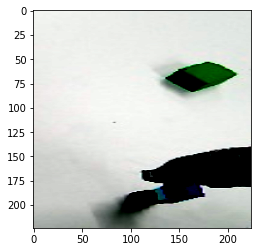

In [3]:
# Crop area for tower building (and show image to sanity check)
example_i, example_data = next(enumerate(train_loader, 0))
loaded_img = example_data["image"][0]
print(loaded_img[0])
plt.imshow(loaded_img.permute(1,2,0))
plt.show()


In [0]:
print("Beginning Training")
full_model.train()
num_epochs = 30
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Epoch:{epoch+1}/{num_epochs}")
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        img_ins, pose_ins, controls = data["image"], data["pose"], data["control"]
        img_ins, pose_ins, controls = img_ins.to(device, dtype=torch.float), pose_ins.to(device), controls.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = full_model(img_ins, pose_ins)
        loss = loss_criterion(outputs, controls)
        loss.backward()
        optimizer.step()

        # print statistics
        current_loss = loss.item()
        running_loss += current_loss
        print(f"Batch {i + 1} of {len(train_loader)}, loss: {current_loss}", end='\r', flush=True)
    print(f"Avg Loss: {running_loss / len(train_loader)}")

print("Finished Training")
torch.save(full_model.state_dict(), "./logs/e2e_control_full.pt")



In [4]:
# Load an existing model
full_model = ImageAndJointsNet(224, 224, 8)
full_model.load_state_dict(torch.load("./logs/e2e_control_full.pt"))
full_model.to(device)


Linear Input Size: 134832


ImageAndJointsNet(
  (conv1): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=134832, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=40, out_features=8, bias=True)
)

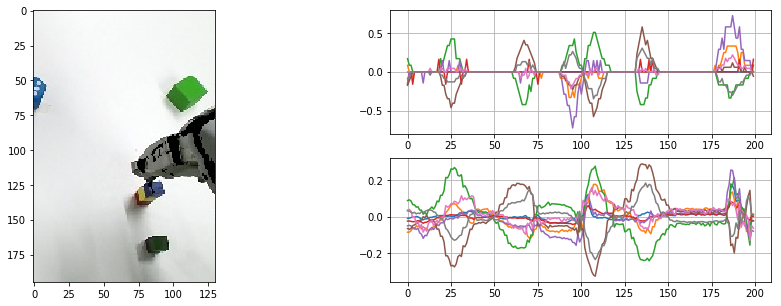

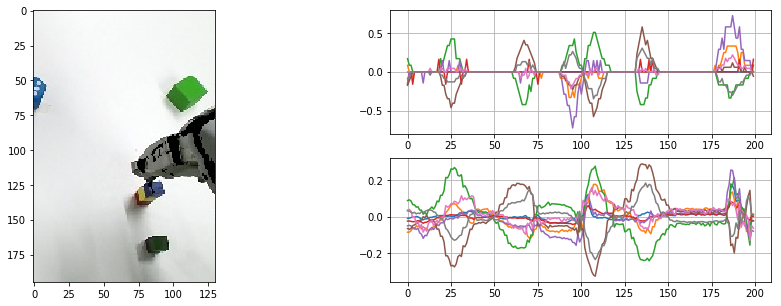

In [5]:
# Show attribution video
fig = plt.figure(figsize=(15,5))
img_heatmap_ax = fig.add_subplot(1, 2, 1)
control_ax = fig.add_subplot(2, 2, 2)
control_est_ax = fig.add_subplot(2, 2, 4)

heatmap = np.zeros((224, 224))

c = []
cest = []

full_model.eval()
for idx in range(200):
    print(idx)
    data = train_set[idx]
    im_in, pose = data["image"], data["pose"]
    im_in, pose = im_in.to(device), pose.to(device)
    controls = data["control"]
    
    c.append(controls.numpy())

    # Get attribution prior
    # TODO: Q - What is the "attribution prior?"
    im_original = cv2.imread(image_paths[idx])


    outputs = full_model(im_in.unsqueeze(0), pose.unsqueeze(0))
    cest.append(outputs.data.cpu().numpy())

    """
    # Set Lxd to size of image, then blur a heatmap onto it
    heatmap = get_heatmap(full_model, pose, im_in)
    Lxd = np.zeros((im_original.shape[0],im_original.shape[1]))
    Lxd[125:320,360:450] = cv2.resize(heatmap,(450-360,320-125))

    Lxd = cv2.GaussianBlur(Lxd**3,(15,15),5)
    Lxd = Lxd / np.sum(Lxd)
    """


    # Display the relevant portion of the image
    # Then overlay a semi-transparent "heatmap" on top of it
    img_heatmap_ax.cla()  # cla = Clear axis
    img_heatmap_ax.imshow(im_original[125:320, 320:450, [2,1,0]])
    # img_heatmap_ax.imshow(Lxd[125:320, 360:450], alpha=0.5)

    # Plot the control velocities over time
    control_ax.cla()
    control_ax.plot(np.squeeze(np.array(c)))
    control_ax.grid()  # Literally just "show a grid" on the figure

    # Plot the estimated velocities over time
    control_est_ax.cla()
    control_est_ax.plot(np.squeeze(np.array(cest)))
    control_est_ax.grid()

    # Get rid of previous image, then display the latest one
    display.clear_output(wait=True)
    display.display(plt.gcf())
